# DHIS2 - Tuning HDBSCAN parameters and running clustering

# Inputs
- Absolute path to the directory with .csv files
- Absolute path to the shapefile for your geography
- Absolute path to the shapefile for your geofile

```
!pip install --upgrade pip
!pip install fuzzywuzzy
!conda install -c conda-forge pyshp
!conda install -c conda-forge pyproj
!conda install -c conda-forge proj4
```

In [1]:
import os
import re
import glob
import conda
import hdbscan
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from config import Config
from collections import Counter
from matplotlib import pyplot as plt
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection

In [2]:
DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/'
SHAPEFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/geo_files/gadm36_BGD_shp/gadm36_BGD_2'
GEOFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/geo_files/geos_svrs.xlsx'
OUTPUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/childhealth'
GEO_LEVEL = 'districts'

In [3]:
def get_files_list(input_dir):
    input_files = glob.glob(input_dir + "/District_*_NAME.csv")
    return input_files


def read_data(files_list):
    data_dict = {}
    for file in files_list:
        data_dict[file] = pd.read_csv(file)
        data_dict[file].rename(columns={'True':'geo'}, inplace=True)
    return data_dict


def check_type(ddict):
    check_list = []
    for key, df in ddict.items():
        df_check_list = [var == 'int64' or var == 'float64' for var in df.dtypes]
        check_list.append(all(df_check_list))
    return all(check_list)


def check_geovar(ddict):
    check_list = []
    for key, df in ddict.items():
        if df.columns[0] == 'geo':
            check_list.append(True)
        else:
            check_list.append(False)
    return all(check_list) 


def check_data(ddict):
    return check_type(ddict) and check_geovar(ddict)


def concat_data1(ddict):
    dlist = []
    for key, df in ddict.items():
        print(key[-13:-9])
        df['year'] = key[-13:-9]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist, axis=0, sort=True)
    out['geo'] = out['geo'].astype(str).str.cat(out['year'].astype(str), sep=" ")
    out = out.drop(['year'], axis=1)
    return out


def concat_data2(ddict):
    dlist = []
    for key, df in ddict.items():
        print(key[-13:-9])
        df['year'] = key[-13:-9]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist, axis=0, sort=True)
    if Counter([len(str(var)) for var in out['geo']]) != 1:
        out['geo'] = out['geo'].astype(str).str.pad(width=2, side='left', fillchar='0')
    return out


def create_output_dir(output_dir):
    dir_list = [name for name in os.listdir(os.path.split(output_dir)[0]) if os.path.isdir(name)]
    try:
        os.mkdir(os.path.split(output_dir)[1])
    except FileExistsError:
        print("Directory already present!")


def evaluate_hdbscan(input_df, min_samples, min_cluster_size, 
                     output, cluster_selection_method, 
                     fmin_samples, fmin_cluster_size,
                     prune=False, plot=True):
    samples = list(itertools.product(min_samples, min_cluster_size))
    counter = 0
    models = pd.DataFrame(columns=['min_samples',
                                   'min_cluster_size',
                                   'num_clusters_including_unclustered',
                                   'percent_of_unclustered_geos',
                                   'percent_of_maxclass',],index=range(len(samples)))
    geo = input_df['geo']
    input_df = input_df.drop('geo', axis=1)
    df = input_df.copy(deep=True)
    for iteration in samples:
        model = hdbscan.HDBSCAN(min_samples=int(iteration[0]), 
                                min_cluster_size=int(iteration[1]), 
                                metric='euclidean', 
                                algorithm='best',
                                cluster_selection_method=cluster_selection_method, prediction_data=False).fit(df)
        models.loc[counter,'min_cluster_size'] = iteration[1]
        models.loc[counter, 'min_samples'] = iteration[0]
        models.loc[counter, 'num_clusters_including_unclustered'] = len(Counter(model.labels_))
        tmp_dict = dict(Counter(model.labels_))
        total = sum([v for k,v in tmp_dict.items()])
        tmp_dict = {k:round(v/total*100,2) for k,v in tmp_dict.items()}
        try:
            models.loc[counter, 'percent_of_unclustered_geos'] = tmp_dict.pop(-1)
        except KeyError as error:
            models.loc[counter, 'percent_of_unclustered_geos'] = 0 
        if len(tmp_dict) > 1:
            models.loc[counter, 'percent_of_maxclass'] = tmp_dict[max(tmp_dict.items(), key=operator.itemgetter(1))[0]]
        else:
            models.loc[counter, 'percent_of_maxclass'] = 100
        counter += 1
    if prune:
        out_model = hdbscan.HDBSCAN(min_samples=int(fmin_samples), 
                                min_cluster_size=int(fmin_cluster_size), 
                                metric='euclidean', 
                                algorithm='best',
                                cluster_selection_method=cluster_selection_method, prediction_data=False).fit(df)

    else:
        out_model = None
    models.to_csv(os.path.split(output)[1] + "/models_overview.csv", index=False, index_label=False)
    if plot:
        plt.rcParams['figure.figsize'] = [20,10]
        plt.plot(models['num_clusters_including_unclustered'], label='Number of clusters including unclustered')
        plt.plot(models['percent_of_unclustered_geos'], label='Percent of unclustered geographies')
        plt.plot(models['percent_of_maxclass'], label='Size of larges cluster (%)')
        plt.savefig(os.path.split(output)[1] + "/finetune_parameteres.jpeg")
        plt.legend()
        plt.show()
    del(input_df, df)
    return models, out_model


def cluster_data(input_df, f_min_samples, f_min_cluster_size, cluster_selection_method):
    df = input_df.copy(deep=True)
    cluster_data = df.drop(['geo', 'year'], axis=1)
    print(cluster_data.columns)
    model = hdbscan.HDBSCAN(min_samples=int(f_min_samples), 
                            min_cluster_size=int(f_min_cluster_size), 
                            metric='euclidean', 
                            algorithm='best', 
                           cluster_selection_method=cluster_selection_method).fit(cluster_data)
    print(Counter(model.labels_))
    df['class'] = model.labels_
    return df
    

def create_mapobject(shp_path, shp_name):
    m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='c')
    m.readshapefile(shapefile=shp_path, name=shp_name, drawbounds=True)
    return m


def colors2clusters(df_input, cluster_var):
    df = df_input.copy(deep=True)
    df['colors'] = df[cluster_var].astype('category')
    labs = list(df['colors'].cat.categories)
    clusters = list(df[cluster_var].unique())
    colors = sns.color_palette('Paired', len(clusters)).as_hex()
    df['colors'] = df['colors'].cat.rename_categories(colors)
    cols = list(df['colors'].cat.categories)
    return df, list(zip(labs,cols))


def data2map(mapobj, mapobj_key, data, data_key):
    for district in mapobj.districts_info:
        district['CLUSTER'] = data.loc[data[data_key] == district[mapobj_key],'colors'][0]
    return mapobj


def plot_geos(mapobj, mapobj_key, labels_colors, title, output):
    geo_names = []
    for shape_dict in mapobj.districts_info:
        geo_names.append(int(shape_dict[mapobj_key]))
    ax = plt.gca()
    for info, shape in zip(mapobj.districts_info, mapobj.districts):
        poly = Polygon(shape, facecolor=info['CLUSTER'], edgecolor=info['CLUSTER'])
        ax.add_patch(poly)
    legend_elements = [Line2D([0], [0], marker="s", color=col, label=label, markerfacecolor=col, markersize=25)
                   for label, col in labels_colors] 
    plt.legend(handles=legend_elements, loc='upper right',borderpad=2)
    plt.title(title)
    plt.savefig(os.path.join(output, title + ".jpeg"))
    plt.show()
    plt.close()


def plot_clusters(input_df, shapefile, geo_level, project, output):
    df = input_df.copy(deep=True)
    plt.rcParams['figure.figsize'] = [10,10]
    for year in sorted(list(df['year'].unique())):
        m = create_mapobject(shp_path=shapefile,shp_name=geo_level)
        tmp = df[df['year'] == year]
        print(tmp['year'].unique())
        m = data2map(mapobj=m, mapobj_key='CC_2', data=tmp, data_key='geo')
        plot_geos(mapobj=m, mapobj_key='CC_2',labels_colors=labs_cols, title=project + str(year), output=output)
    

def get_statistics(input_df, output, title):
    df = input_df.copy(deep=True)
    out = {}
    for year in df['year'].unique():
        tmp = df[df['year'] == year]
        variables = list(tmp.drop(['year', 'geo', 'class', 'colors'], axis=1).columns)
        tmp = tmp.drop(['year','geo'], axis=1)
        tmpgroupby = tmp.groupby('class')
        output_year = [] 
        for variable in variables:
            print(variable)
            tmp = tmpgroupby[variable].agg([np.mean, np.std, np.max, np.min]).transpose()
            tmp['var'] = variable
            output_year.append(tmp)
        out[year] = pd.concat(output_year, axis=0)
        out[year].to_csv(os.path.join(output, title+"_" +str(year) + ".csv"),index=False, index_label=False)
    return out


def update_geo1(input_df, input_geo, geo_var):
    df = input_df.copy(deep=True)
    geodata = pd.read_excel(input_geo)
    geodata['dv'] = geodata['dv'].astype(str)
    geodata['zl'] = geodata['zl'].astype(str)
    geodata['dv'] = geodata['dv'].str.pad(width=2,side='left',fillchar='0')
    geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
    geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
    geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name2']]
    geodata = geodata.drop_duplicates()
    display(geodata.head())
    display(df.head())
    df = df.merge(right=geodata, left_on='geo', right_on=geo_var)
    print(df.shape)
    df = df.drop(['dv', 'Div_Name', 'zl', 'Zila_Name2', 'geo'], axis=1)
    df.rename(columns={'geo_full':'geo'}, inplace=True)
    return df


def update_geo2(input_df, input_geo, geo_var):
    df = input_df.copy(deep=True)
    geodata = pd.read_excel(input_geo)
    geodata['dv'] = geodata['dv'].astype(str)
    geodata['zl'] = geodata['zl'].astype(str)
    geodata['dv'] = geodata['dv'].str.pad(width=2,side='left',fillchar='0')
    geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
    geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
    geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name2']]
    geodata = geodata.drop_duplicates()
    df = df.merge(right=geodata, left_on='geo', right_on=geo_var)
    df.rename(columns={'geo_full':'geo'}, inplace=True)
    return df

def imput_missing(input_df):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if df[var].dtype != 'object':
            if df[var].isna().value_counts()[0]/df[var].shape[0] != 1.:
                tmp = df[var].fillna(np.mean(df[var]))
                df = df.drop(var,axis=1)
                df[var] = tmp
    return df


def output_class(input_df):
    df = input_df.copy(deep=True)
    out = list()
    for geo_var in df['geo'].unique():
        tmp = df[df['geo'] == geo_var]
        tmp = tmp[['geo','year', 'class']]
        tmp = tmp.pivot(index='geo', columns='year', values='class')
        tmp.reset_index(inplace=True)
        out.append(tmp)
    output = pd.concat(out, axis=0)
    output = output.reset_index(drop=True)
    return output

def output_table(input_df, out, name):
    df = input_df.copy(deep=True)
    remove = ['geo','year','colors']
    columns = df.columns
    variables = list(set(columns).difference(set(remove)))
    print(variables)
    out_min = df[variables].groupby('class').min().round(4)
    out_max = df[variables].groupby('class').max().round(4)
    out_mean = df[variables].groupby('class').mean().round(1)
    t = out_min.astype(str).add(' - ').add(out_mean.astype(str))
    t = t.astype(str).add(' - ').add(out_max.astype(str))
    t = t.transpose()
    print(out+"/"+name+".csv")
    t.to_csv(out+"/"+name+".csv", index_label=False)
    return t


## PART 1: Fine-tuning the clustering model
### STEP 1: Get files list

In [4]:
dfiles = get_files_list(input_dir=DATA)
dfiles

['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2012_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2013_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2018_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2009_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2015_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2014_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2011_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2010_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2016_NAME.csv',
 '/Users/e

### STEP 2: Read data

In [5]:
ddata = read_data(files_list=dfiles)

### STEP 3: Check data 

In [6]:
dcheck = check_data(ddict=ddata)
dcheck

False

### STEP 4: Concat data 

In [7]:
ddf = concat_data1(ddict=ddata)

2012
2013
2018
2009
2015
2014
2011
2010
2016
2017


### STEP 5: Create output dir

In [8]:
create_output_dir(output_dir=OUTPUT)

Directory already present!


### STEP 6: Data and geo clean up child health data

In [9]:
ddf['geo'] = ddf['geo'].str.replace(" District", "")
ddf.head()

,01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Total Complicated Mother,01MaternalHealth: Total No. of pregnant mothers with obstetric complication,...,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_fw product distribution closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for logistic closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for vaccine/diluent closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_supply book closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_temperature chart closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_zip lock bag closing balance,AntenatalCare(ANC): 1st Visit ANC,AntenatalCare(ANC): 2nd Visit ANC,AntenatalCare(ANC): 3rd & more ANC,geo
0,50.0,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006,5637.0,3244.0,...,47.8,36.9,36.9,50.9,330.0,311.0,NaN,NaN,NaN,Bagerhat 2012
1,0.0,11.3,88.2,0.0770,0.08,0.42,0.0042,0.0008,463.0,316.0,...,64.0,38.0,29.0,32.0,218.0,534.0,NaN,NaN,NaN,Bandarban 2012
2,20.0,49.4,50.0,0.0763,0.31,1.13,0.0113,0.0031,3558.0,3360.0,...,19.0,14.0,18.0,8.0,5.0,1240.0,NaN,NaN,NaN,Barguna 2012
3,0.0,65.4,34.5,0.0039,0.04,0.78,0.0078,0.0004,4223.0,4128.0,...,55.0,50.0,45.0,47.0,897.0,2428.0,NaN,NaN,NaN,Barishal 2012
4,26.0,22.1,77.4,0.2378,0.16,2.75,0.0275,0.0016,9348.0,9075.0,...,43.0,32.0,30.0,29.0,734.9,2772.4,NaN,NaN,NaN,Bhola 2012


```
childhealth_vars = [var for var in ddf.columns if bool(re.search(r"02ChildHealth: IMCI",var))]
print(childhealth_vars)
childhealth_data = ddf[['geo']+childhealth_vars]
childhealth_data = childhealth_data.drop(['02ChildHealth: IMCI Total Child'],axis=1)
childhealth_data.head()
```

In [10]:
childhealth_vars = [var for var in ddf.columns if bool(re.search(r"02ChildHealth",var))]
childhealth_data = ddf[['geo']+childhealth_vars]
childhealth_data = childhealth_data.drop(['02ChildHealth: IMCI Total Child', 
                                          '02ChildHealth: % of neonatal death reported individually'],axis=1)
childhealth_data.head()
childhealth_data.columns

Index(['geo',
       '02ChildHealth: % of breast feeding initiated within 1 hour by CSBA',
       '02ChildHealth: IMCI Stunting (%)',
       '02ChildHealth: IMCI Underweight (%)',
       '02ChildHealth: IMCI Wasting (%)',
       '02ChildHealth: Neonatal Case fatality rate (EmOC)',
       '02ChildHealth: Percentage of diarrhea reported at facility',
       '02ChildHealth: Percentage of pneumonia reported at facility'],
      dtype='object')

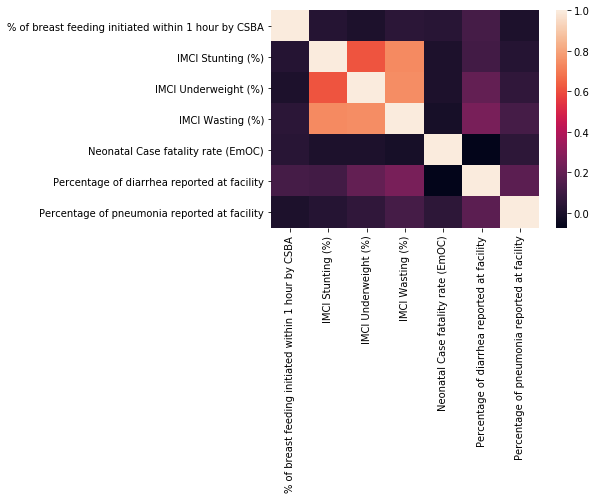

In [11]:
corr = childhealth_data.corr()
labels = [var.replace("02ChildHealth: ", "") for var in corr.columns]

sns.heatmap(corr, 
        xticklabels=labels,
        yticklabels=labels)

In [12]:
for var in childhealth_data.columns:
    print(childhealth_data[var].isna().value_counts()/childhealth_data.shape[0])
childhealth_data = imput_missing(input_df=childhealth_data)  
for var in childhealth_data.columns:
    print(childhealth_data[var].isna().value_counts()/childhealth_data.shape[0])

False    1.0
Name: geo, dtype: float64
False    1.0
Name: 02ChildHealth: % of breast feeding initiated within 1 hour by CSBA, dtype: float64
False    1.0
Name: 02ChildHealth: IMCI Stunting (%), dtype: float64
False    1.0
Name: 02ChildHealth: IMCI Underweight (%), dtype: float64
False    1.0
Name: 02ChildHealth: IMCI Wasting (%), dtype: float64
False    1.0
Name: 02ChildHealth: Neonatal Case fatality rate (EmOC), dtype: float64
False    1.0
Name: 02ChildHealth: Percentage of diarrhea reported at facility, dtype: float64
False    1.0
Name: 02ChildHealth: Percentage of pneumonia reported at facility, dtype: float64
False    1.0
Name: geo, dtype: float64
False    1.0
Name: 02ChildHealth: % of breast feeding initiated within 1 hour by CSBA, dtype: float64
False    1.0
Name: 02ChildHealth: IMCI Stunting (%), dtype: float64
False    1.0
Name: 02ChildHealth: IMCI Underweight (%), dtype: float64
False    1.0
Name: 02ChildHealth: IMCI Wasting (%), dtype: float64
False    1.0
Name: 02ChildHealth

### STEP 6: Fine tune and analyze the data and obtain the output of paramaters

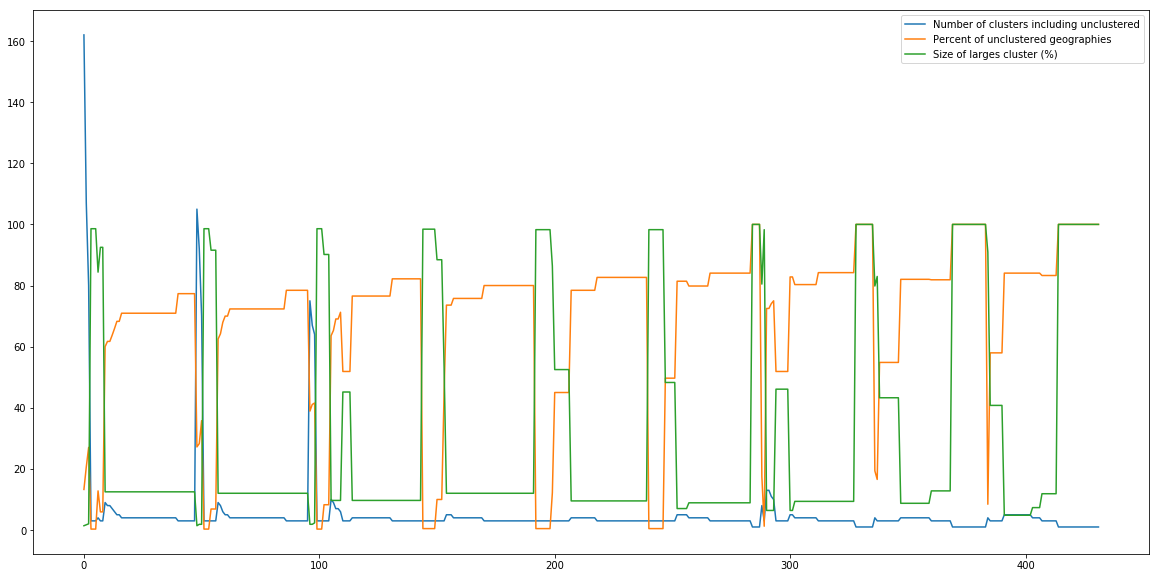

In [13]:
tmp, out = evaluate_hdbscan(input_df=childhealth_data, 
                       min_samples=Config.tune_min_sample, 
                       min_cluster_size=Config.tune_min_cluster,
                       output=OUTPUT, cluster_selection_method ='eom',
                       fmin_samples=3, fmin_cluster_size=12,
                       prune=True)

In [14]:
tmp = tmp[tmp['num_clusters_including_unclustered'] < 10]
tmp = tmp.loc[tmp['num_clusters_including_unclustered'] > 3].sort_values(by='percent_of_unclustered_geos', ascending=True)
tmp.sort_values(by='percent_of_unclustered_geos', ascending=True).head(50)

,min_samples,min_cluster_size,num_clusters_including_unclustered,percent_of_unclustered_geos,percent_of_maxclass
384,9,2,4,8.44,90.94
6,1,8,4,12.81,84.38
288,7,2,8,17.5,80.47
336,8,2,4,19.38,79.84
9,1,11,9,60,12.5
10,1,12,8,61.72,12.5
11,1,13,8,61.72,12.5
57,2,11,9,62.5,12.03
12,1,14,7,63.75,12.5
58,2,12,8,64.22,12.03


# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------

## PART 2: Running the clustering
### STEP 1: Get files list

In [15]:
dfiles = get_files_list(input_dir=DATA)
print(dfiles)

['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2012_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2013_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2018_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2009_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2015_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2014_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2011_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2010_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2016_NAME.csv', '/Users/edinhamzic

### STEP 2: Read data

In [16]:
ddata = read_data(files_list=dfiles)

### STEP3: Check data 

In [17]:
dcheck = check_data(ddict=ddata)
dcheck

False

### STEP4: Concat data 

In [18]:
ddf = concat_data2(ddict=ddata)
display(ddf.head())
print(ddf.shape)
print(ddf.shape)


2012
2013
2018
2009
2015
2014
2011
2010
2016
2017


,01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Total Complicated Mother,01MaternalHealth: Total No. of pregnant mothers with obstetric complication,...,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for logistic closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for vaccine/diluent closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_supply book closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_temperature chart closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_zip lock bag closing balance,AntenatalCare(ANC): 1st Visit ANC,AntenatalCare(ANC): 2nd Visit ANC,AntenatalCare(ANC): 3rd & more ANC,geo,year
0,50.0,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006,5637.0,3244.0,...,36.9,36.9,50.9,330.0,311.0,NaN,NaN,NaN,Bagerhat District,2012
1,0.0,11.3,88.2,0.0770,0.08,0.42,0.0042,0.0008,463.0,316.0,...,38.0,29.0,32.0,218.0,534.0,NaN,NaN,NaN,Bandarban District,2012
2,20.0,49.4,50.0,0.0763,0.31,1.13,0.0113,0.0031,3558.0,3360.0,...,14.0,18.0,8.0,5.0,1240.0,NaN,NaN,NaN,Barguna District,2012
3,0.0,65.4,34.5,0.0039,0.04,0.78,0.0078,0.0004,4223.0,4128.0,...,50.0,45.0,47.0,897.0,2428.0,NaN,NaN,NaN,Barishal District,2012
4,26.0,22.1,77.4,0.2378,0.16,2.75,0.0275,0.0016,9348.0,9075.0,...,32.0,30.0,29.0,734.9,2772.4,NaN,NaN,NaN,Bhola District,2012


(640, 350)
(640, 350)


### STEP 5: Update geography

In [19]:
ddf['geo'] = ddf['geo'].str.replace(" District", "")
ddf = update_geo1(input_df=ddf,input_geo=GEOFILE, geo_var='Zila_Name2')

,geo_full,dv,Div_Name,zl,Zila_Name2
0,1004,10,Barisal,04,Barguna
17,1006,10,Barisal,06,Barishal
111,1009,10,Barisal,09,Bhola
143,1042,10,Barisal,42,Jhalokati
157,1078,10,Barisal,78,Patuakhali


,01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Total Complicated Mother,01MaternalHealth: Total No. of pregnant mothers with obstetric complication,...,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for logistic closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for vaccine/diluent closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_supply book closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_temperature chart closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_zip lock bag closing balance,AntenatalCare(ANC): 1st Visit ANC,AntenatalCare(ANC): 2nd Visit ANC,AntenatalCare(ANC): 3rd & more ANC,geo,year
0,50.0,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006,5637.0,3244.0,...,36.9,36.9,50.9,330.0,311.0,NaN,NaN,NaN,Bagerhat,2012
1,0.0,11.3,88.2,0.0770,0.08,0.42,0.0042,0.0008,463.0,316.0,...,38.0,29.0,32.0,218.0,534.0,NaN,NaN,NaN,Bandarban,2012
2,20.0,49.4,50.0,0.0763,0.31,1.13,0.0113,0.0031,3558.0,3360.0,...,14.0,18.0,8.0,5.0,1240.0,NaN,NaN,NaN,Barguna,2012
3,0.0,65.4,34.5,0.0039,0.04,0.78,0.0078,0.0004,4223.0,4128.0,...,50.0,45.0,47.0,897.0,2428.0,NaN,NaN,NaN,Barishal,2012
4,26.0,22.1,77.4,0.2378,0.16,2.75,0.0275,0.0016,9348.0,9075.0,...,32.0,30.0,29.0,734.9,2772.4,NaN,NaN,NaN,Bhola,2012


(640, 355)


### STEP 6: Create output dir

In [20]:
create_output_dir(output_dir=Config.output)

Directory already present!


### STEP 6: Preparing data

In [21]:

ddf.columns
childhealth_vars = [var for var in ddf.columns if bool(re.search(r"02ChildHealth:",var))]
print(childhealth_vars)
childhealth_data = ddf[['geo', 'year']+childhealth_vars]
childhealth_data = childhealth_data.drop(['02ChildHealth: IMCI Total Child', 
                                         '02ChildHealth: % of neonatal death reported individually'],axis=1)
childhealth_data.head()


['02ChildHealth: % of breast feeding initiated within 1 hour by CSBA', '02ChildHealth: % of neonatal death reported individually', '02ChildHealth: IMCI Stunting (%)', '02ChildHealth: IMCI Total Child', '02ChildHealth: IMCI Underweight (%)', '02ChildHealth: IMCI Wasting (%)', '02ChildHealth: Neonatal Case fatality rate (EmOC)', '02ChildHealth: Percentage of diarrhea reported at facility', '02ChildHealth: Percentage of pneumonia reported at facility']


,geo,year,02ChildHealth: % of breast feeding initiated within 1 hour by CSBA,02ChildHealth: IMCI Stunting (%),02ChildHealth: IMCI Underweight (%),02ChildHealth: IMCI Wasting (%),02ChildHealth: Neonatal Case fatality rate (EmOC),02ChildHealth: Percentage of diarrhea reported at facility,02ChildHealth: Percentage of pneumonia reported at facility
0,4001,2012,95.3,1.2,2.1,1.2,0.1322,11.60,4.44
1,4001,2013,95.3,1.1,1.9,1.0,0.1483,11.12,3.81
2,4001,2018,95.1,1.9,3.3,1.8,0.1649,11.42,3.49
3,4001,2009,95.3,1.9,3.3,1.8,0.1568,11.11,3.51
4,4001,2015,85.1,1.7,3.3,1.2,0.1353,11.06,3.30


```
ddf.columns
childhealth_vars = [var for var in ddf.columns if bool(re.search(r"02ChildHealth: IMCI",var))]
print(childhealth_vars)
childhealth_data = ddf[['geo', 'year']+childhealth_vars]
childhealth_data = childhealth_data.drop(['02ChildHealth: IMCI Total Child'],axis=1)
childhealth_data.head()
```

In [22]:
childhealth_data = imput_missing(input_df=childhealth_data)            

## STEP 7: Clustering data and assigning collors

##  Material and methods:
- Key indicators for child health (DHIS2 program): 
    - Percent of breast feeding initiated within 1 hour by CSBA
    - Percent of stunting by IMCI
    - Percent of underweight by IMCI
    - Percent of wasting by IMCI
    - Neonatal case fatality rate (EmOC)
    - Percentage of diarrhea reported at facility
    - Percentage of pneumonia reported at facility
- Time period from 2009 to 2018 at zila level
- HDBSCAN paramteres:
    - **Option 1**: Small number of unclustered, small number of clusters, ubalanced clusters	
        - cluster_selection_method:'eom'
        - min_samples=1
        - min_cluster_size=8
        - number of clusters: 4
        - percent of unclustered: 12.81%
        - max size of cluster: 84.38%		
    - **Option 2**: Large number of unclustered, medium number of clusters, relatively balanced clusters
        - cluster_selection_method:'eom'
        - min_samples=1
        - min_cluster_size=11
        - number of clusters: 9
        - percent of unclustered: 60%
        - max size of cluster: 12.5%
    - **Option 3**: Large number of unclustered, medium number of clusters, relatively balanced clusters
        - cluster_selection_method:'leaf'
        - min_samples=1
        - min_cluster_size=12
        - number of clusters: 9
        - percent of unclustered: 64.06%
        - max size of cluster: 10.16%

###  Option 1: 

In [23]:
print(childhealth_data.shape)
datad_option1 = cluster_data(input_df=childhealth_data, f_min_samples=1, f_min_cluster_size=8, cluster_selection_method='eom')
print(Counter(datad_option1['class']))
datad_option1, labs_cols = colors2clusters(df_input=datad_option1, cluster_var='class')
display(datad_option1.head())

(640, 9)
Index(['02ChildHealth: % of breast feeding initiated within 1 hour by CSBA',
       '02ChildHealth: IMCI Stunting (%)',
       '02ChildHealth: IMCI Underweight (%)',
       '02ChildHealth: IMCI Wasting (%)',
       '02ChildHealth: Neonatal Case fatality rate (EmOC)',
       '02ChildHealth: Percentage of diarrhea reported at facility',
       '02ChildHealth: Percentage of pneumonia reported at facility'],
      dtype='object')
Counter({2: 540, -1: 82, 0: 10, 1: 8})
Counter({2: 540, -1: 82, 0: 10, 1: 8})


,geo,year,02ChildHealth: % of breast feeding initiated within 1 hour by CSBA,02ChildHealth: IMCI Stunting (%),02ChildHealth: IMCI Underweight (%),02ChildHealth: IMCI Wasting (%),02ChildHealth: Neonatal Case fatality rate (EmOC),02ChildHealth: Percentage of diarrhea reported at facility,02ChildHealth: Percentage of pneumonia reported at facility,class,colors
0,4001,2012,95.3,1.2,2.1,1.2,0.1322,11.60,4.44,2,#33a02c
1,4001,2013,95.3,1.1,1.9,1.0,0.1483,11.12,3.81,2,#33a02c
2,4001,2018,95.1,1.9,3.3,1.8,0.1649,11.42,3.49,2,#33a02c
3,4001,2009,95.3,1.9,3.3,1.8,0.1568,11.11,3.51,2,#33a02c
4,4001,2015,85.1,1.7,3.3,1.2,0.1353,11.06,3.30,2,#33a02c


###  Option 2: 

In [24]:
print(childhealth_data.shape)
datad_option2 = cluster_data(input_df=childhealth_data, f_min_samples=1, f_min_cluster_size=11, cluster_selection_method='eom')
print(Counter(datad_option2['class']))
datad_option2, labs_cols = colors2clusters(df_input=datad_option2, cluster_var='class')
display(datad_option2.head())

(640, 9)
Index(['02ChildHealth: % of breast feeding initiated within 1 hour by CSBA',
       '02ChildHealth: IMCI Stunting (%)',
       '02ChildHealth: IMCI Underweight (%)',
       '02ChildHealth: IMCI Wasting (%)',
       '02ChildHealth: Neonatal Case fatality rate (EmOC)',
       '02ChildHealth: Percentage of diarrhea reported at facility',
       '02ChildHealth: Percentage of pneumonia reported at facility'],
      dtype='object')
Counter({-1: 384, 7: 80, 6: 65, 5: 41, 1: 17, 2: 15, 4: 14, 3: 13, 0: 11})
Counter({-1: 384, 7: 80, 6: 65, 5: 41, 1: 17, 2: 15, 4: 14, 3: 13, 0: 11})


,geo,year,02ChildHealth: % of breast feeding initiated within 1 hour by CSBA,02ChildHealth: IMCI Stunting (%),02ChildHealth: IMCI Underweight (%),02ChildHealth: IMCI Wasting (%),02ChildHealth: Neonatal Case fatality rate (EmOC),02ChildHealth: Percentage of diarrhea reported at facility,02ChildHealth: Percentage of pneumonia reported at facility,class,colors
0,4001,2012,95.3,1.2,2.1,1.2,0.1322,11.60,4.44,7,#cab2d6
1,4001,2013,95.3,1.1,1.9,1.0,0.1483,11.12,3.81,7,#cab2d6
2,4001,2018,95.1,1.9,3.3,1.8,0.1649,11.42,3.49,7,#cab2d6
3,4001,2009,95.3,1.9,3.3,1.8,0.1568,11.11,3.51,7,#cab2d6
4,4001,2015,85.1,1.7,3.3,1.2,0.1353,11.06,3.30,-1,#a6cee3


### Option 3: 

In [25]:
print(childhealth_data.shape)
datad_option3 = cluster_data(input_df=childhealth_data, f_min_samples=1, f_min_cluster_size=11, cluster_selection_method='leaf')
print(Counter(datad_option3['class']))
datad_option3, labs_cols = colors2clusters(df_input=datad_option3, cluster_var='class')
display(datad_option3.head())

(640, 9)
Index(['02ChildHealth: % of breast feeding initiated within 1 hour by CSBA',
       '02ChildHealth: IMCI Stunting (%)',
       '02ChildHealth: IMCI Underweight (%)',
       '02ChildHealth: IMCI Wasting (%)',
       '02ChildHealth: Neonatal Case fatality rate (EmOC)',
       '02ChildHealth: Percentage of diarrhea reported at facility',
       '02ChildHealth: Percentage of pneumonia reported at facility'],
      dtype='object')
Counter({-1: 399, 6: 65, 5: 41, 7: 34, 8: 31, 1: 17, 2: 15, 4: 14, 3: 13, 0: 11})
Counter({-1: 399, 6: 65, 5: 41, 7: 34, 8: 31, 1: 17, 2: 15, 4: 14, 3: 13, 0: 11})


,geo,year,02ChildHealth: % of breast feeding initiated within 1 hour by CSBA,02ChildHealth: IMCI Stunting (%),02ChildHealth: IMCI Underweight (%),02ChildHealth: IMCI Wasting (%),02ChildHealth: Neonatal Case fatality rate (EmOC),02ChildHealth: Percentage of diarrhea reported at facility,02ChildHealth: Percentage of pneumonia reported at facility,class,colors
0,4001,2012,95.3,1.2,2.1,1.2,0.1322,11.60,4.44,7,#cab2d6
1,4001,2013,95.3,1.1,1.9,1.0,0.1483,11.12,3.81,7,#cab2d6
2,4001,2018,95.1,1.9,3.3,1.8,0.1649,11.42,3.49,7,#cab2d6
3,4001,2009,95.3,1.9,3.3,1.8,0.1568,11.11,3.51,7,#cab2d6
4,4001,2015,85.1,1.7,3.3,1.2,0.1353,11.06,3.30,-1,#a6cee3


### STEP 9: Getting statistics

In [26]:
output_table(input_df=datad_option1, out=OUTPUT, name="datad_option1")

['02ChildHealth: IMCI Underweight (%)', '02ChildHealth: IMCI Wasting (%)', '02ChildHealth: Percentage of diarrhea reported at facility', '02ChildHealth: IMCI Stunting (%)', '02ChildHealth: Percentage of pneumonia reported at facility', '02ChildHealth: % of breast feeding initiated within 1 hour by CSBA', 'class', '02ChildHealth: Neonatal Case fatality rate (EmOC)']
/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/childhealth/datad_option1.csv


class,-1,0,1,2
02ChildHealth: IMCI Underweight (%),0.16 - 5.5 - 16.8,7.6 - 9.4 - 11.0,1.4 - 2.1 - 2.4,0.07 - 2.2 - 8.5
02ChildHealth: IMCI Wasting (%),0.06 - 1.9 - 6.4,5.3 - 7.1 - 8.5,0.12 - 0.2 - 0.22,0.01 - 0.8 - 5.3
02ChildHealth: Percentage of diarrhea reported at facility,5.45 - 12.1 - 18.96,13.3 - 14.1 - 16.16,6.71 - 7.2 - 8.28,5.88 - 11.6 - 19.42
02ChildHealth: IMCI Stunting (%),0.02 - 2.2 - 6.5,8.7 - 11.4 - 13.7,0.07 - 0.1 - 0.36,0.01 - 1.2 - 7.0
02ChildHealth: Percentage of pneumonia reported at facility,2.44 - 9.0 - 19.64,3.74 - 4.2 - 4.99,11.89 - 14.8 - 16.88,2.11 - 6.4 - 14.77
02ChildHealth: % of breast feeding initiated within 1 hour by CSBA,0.0 - 76.8 - 195.1,93.5 - 95.6 - 96.0,85.0 - 88.2 - 89.5,70.5 - 93.3 - 103.2
02ChildHealth: Neonatal Case fatality rate (EmOC),0.0 - 0.9 - 8.3763,0.0696 - 0.1 - 0.2866,0.0852 - 0.5 - 1.5879,0.0 - 0.6 - 7.2069


In [27]:
output_table(input_df=datad_option2, out=OUTPUT, name='datad_option2')

['02ChildHealth: IMCI Underweight (%)', '02ChildHealth: IMCI Wasting (%)', '02ChildHealth: Percentage of diarrhea reported at facility', '02ChildHealth: IMCI Stunting (%)', '02ChildHealth: Percentage of pneumonia reported at facility', '02ChildHealth: % of breast feeding initiated within 1 hour by CSBA', 'class', '02ChildHealth: Neonatal Case fatality rate (EmOC)']
/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/childhealth/datad_option2.csv


class,-1,0,1,2,3,4,5,6,7
02ChildHealth: IMCI Underweight (%),0.07 - 3.5 - 16.8,0.65 - 1.7 - 2.9,0.28 - 1.4 - 2.8,0.32 - 1.0 - 2.1,2.1 - 3.0 - 3.5,1.1 - 1.9 - 3.5,0.41 - 1.7 - 4.9,0.16 - 1.1 - 4.1,0.29 - 1.8 - 4.6
02ChildHealth: IMCI Wasting (%),0.01 - 1.3 - 8.5,0.62 - 1.2 - 1.8,0.01 - 0.6 - 1.7,0.03 - 0.1 - 0.43,0.8 - 1.1 - 1.4,0.35 - 1.1 - 2.1,0.06 - 0.2 - 0.92,0.01 - 0.4 - 2.1,0.01 - 0.8 - 3.3
02ChildHealth: Percentage of diarrhea reported at facility,5.45 - 12.0 - 19.42,9.33 - 10.0 - 10.77,7.38 - 10.5 - 12.29,7.6 - 8.6 - 8.96,6.39 - 7.4 - 8.55,14.47 - 14.9 - 15.8,7.12 - 8.3 - 9.95,8.99 - 12.6 - 16.77,9.9 - 12.2 - 14.61
02ChildHealth: IMCI Stunting (%),0.01 - 2.0 - 13.7,0.28 - 1.0 - 2.2,0.01 - 0.6 - 1.8,0.09 - 0.3 - 0.59,0.87 - 1.6 - 2.2,0.56 - 1.1 - 2.6,0.07 - 0.3 - 1.5,0.01 - 0.5 - 1.6,0.03 - 0.8 - 2.3
02ChildHealth: Percentage of pneumonia reported at facility,2.11 - 7.4 - 19.64,3.33 - 3.7 - 4.6,4.27 - 5.9 - 7.89,5.83 - 7.5 - 10.69,3.81 - 4.5 - 5.38,7.78 - 8.7 - 9.86,2.3 - 4.7 - 8.6,3.24 - 6.0 - 8.97,3.35 - 6.1 - 9.22
02ChildHealth: % of breast feeding initiated within 1 hour by CSBA,0.0 - 88.9 - 195.1,99.2 - 99.8 - 101.9,80.4 - 83.2 - 86.4,91.8 - 92.9 - 93.2,95.4 - 97.8 - 98.8,96.0 - 98.0 - 98.8,93.9 - 96.6 - 97.8,88.2 - 91.3 - 93.9,92.6 - 96.9 - 100.0
02ChildHealth: Neonatal Case fatality rate (EmOC),0.0 - 0.8 - 8.3763,0.0305 - 0.2 - 0.668,0.0405 - 0.3 - 1.1593,0.0286 - 0.8 - 1.3281,0.0467 - 0.9 - 1.7432,0.1755 - 0.4 - 0.7088,0.0025 - 0.5 - 1.1671,0.0 - 0.4 - 1.7024,0.0 - 0.2 - 0.8813


In [28]:
output_table(input_df=datad_option3, out=OUTPUT, name='datad_option3')

['02ChildHealth: IMCI Underweight (%)', '02ChildHealth: IMCI Wasting (%)', '02ChildHealth: Percentage of diarrhea reported at facility', '02ChildHealth: IMCI Stunting (%)', '02ChildHealth: Percentage of pneumonia reported at facility', '02ChildHealth: % of breast feeding initiated within 1 hour by CSBA', 'class', '02ChildHealth: Neonatal Case fatality rate (EmOC)']
/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/childhealth/datad_option3.csv


class,-1,0,1,2,3,4,5,6,7,8
02ChildHealth: IMCI Underweight (%),0.07 - 3.4 - 16.8,0.65 - 1.7 - 2.9,0.28 - 1.4 - 2.8,0.32 - 1.0 - 2.1,2.1 - 3.0 - 3.5,1.1 - 1.9 - 3.5,0.41 - 1.7 - 4.9,0.16 - 1.1 - 4.1,0.61 - 1.8 - 3.3,0.29 - 1.8 - 3.2
02ChildHealth: IMCI Wasting (%),0.01 - 1.3 - 8.5,0.62 - 1.2 - 1.8,0.01 - 0.6 - 1.7,0.03 - 0.1 - 0.43,0.8 - 1.1 - 1.4,0.35 - 1.1 - 2.1,0.06 - 0.2 - 0.92,0.01 - 0.4 - 2.1,0.16 - 0.6 - 1.8,0.01 - 0.9 - 2.2
02ChildHealth: Percentage of diarrhea reported at facility,5.45 - 12.0 - 19.42,9.33 - 10.0 - 10.77,7.38 - 10.5 - 12.29,7.6 - 8.6 - 8.96,6.39 - 7.4 - 8.55,14.47 - 14.9 - 15.8,7.12 - 8.3 - 9.95,8.99 - 12.6 - 16.77,9.9 - 11.4 - 12.83,11.27 - 12.8 - 14.61
02ChildHealth: IMCI Stunting (%),0.01 - 2.0 - 13.7,0.28 - 1.0 - 2.2,0.01 - 0.6 - 1.8,0.09 - 0.3 - 0.59,0.87 - 1.6 - 2.2,0.56 - 1.1 - 2.6,0.07 - 0.3 - 1.5,0.01 - 0.5 - 1.6,0.14 - 0.6 - 1.9,0.03 - 0.9 - 1.7
02ChildHealth: Percentage of pneumonia reported at facility,2.11 - 7.4 - 19.64,3.33 - 3.7 - 4.6,4.27 - 5.9 - 7.89,5.83 - 7.5 - 10.69,3.81 - 4.5 - 5.38,7.78 - 8.7 - 9.86,2.3 - 4.7 - 8.6,3.24 - 6.0 - 8.97,3.49 - 4.8 - 6.92,5.13 - 7.3 - 8.86
02ChildHealth: % of breast feeding initiated within 1 hour by CSBA,0.0 - 89.1 - 195.1,99.2 - 99.8 - 101.9,80.4 - 83.2 - 86.4,91.8 - 92.9 - 93.2,95.4 - 97.8 - 98.8,96.0 - 98.0 - 98.8,93.9 - 96.6 - 97.8,88.2 - 91.3 - 93.9,94.6 - 95.8 - 97.7,97.4 - 98.7 - 100.0
02ChildHealth: Neonatal Case fatality rate (EmOC),0.0 - 0.7 - 8.3763,0.0305 - 0.2 - 0.668,0.0405 - 0.3 - 1.1593,0.0286 - 0.8 - 1.3281,0.0467 - 0.9 - 1.7432,0.1755 - 0.4 - 0.7088,0.0025 - 0.5 - 1.1671,0.0 - 0.4 - 1.7024,0.0039 - 0.1 - 0.7491,0.0 - 0.2 - 0.8813


In [29]:
clusters = output_class(input_df=datad_option3)
clusters = update_geo2(input_df=clusters, input_geo=GEOFILE, geo_var='geo_full')
clusters = clusters.sort_values([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018], ascending=False)
clusters.to_csv(OUTPUT+"/clusters_paths_option3.csv", index=False, index_label=False)

### STEP 8: Plotting clusters: datad_option1

[2009]


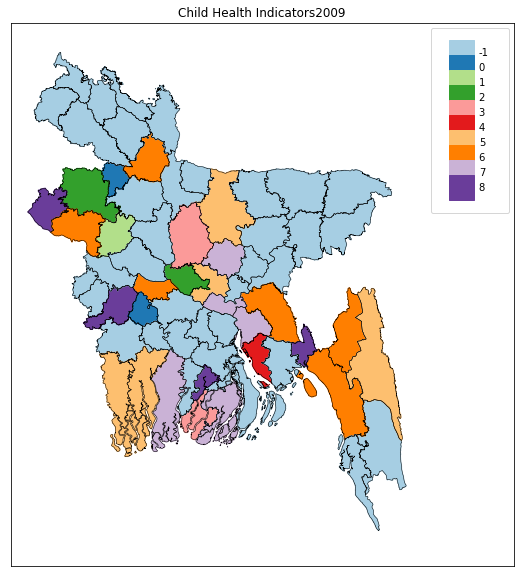

[2010]


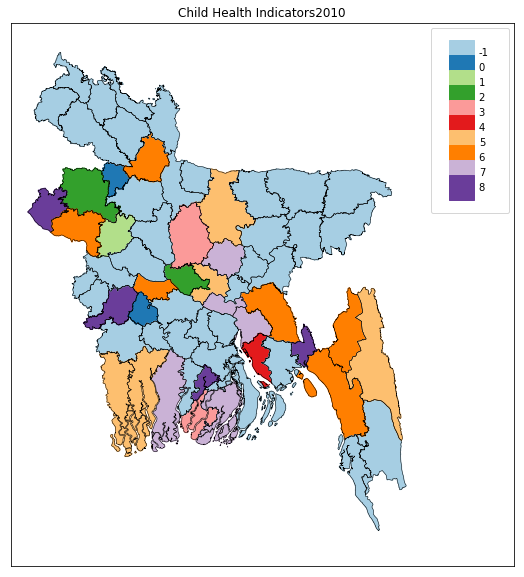

[2011]


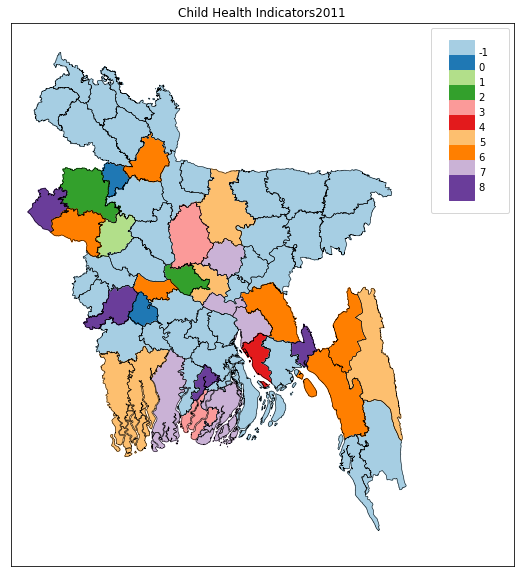

[2012]


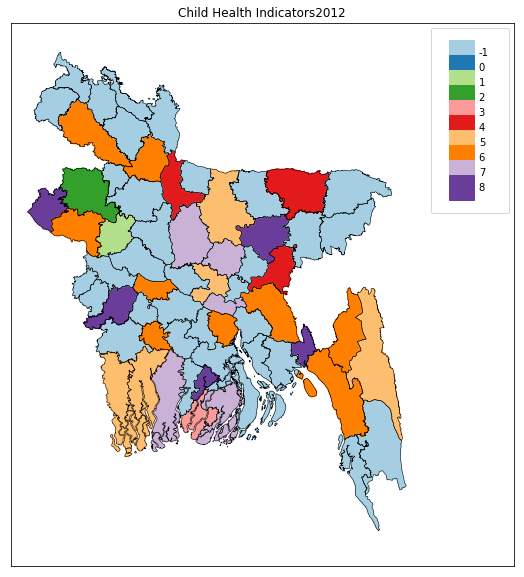

[2013]


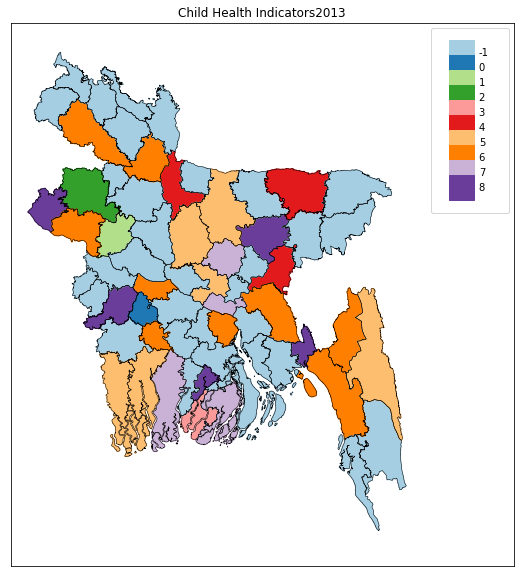

[2014]


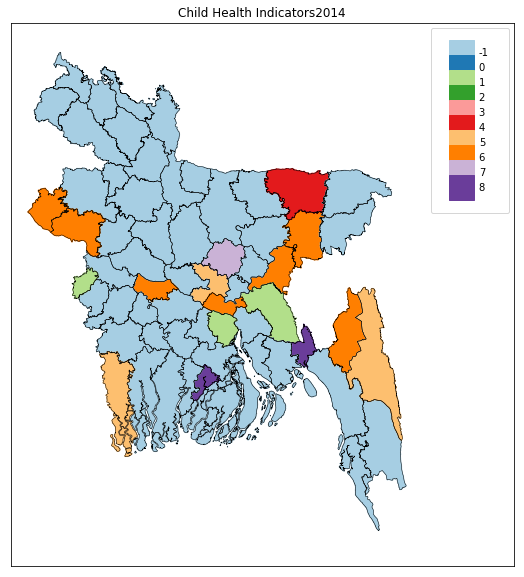

[2015]


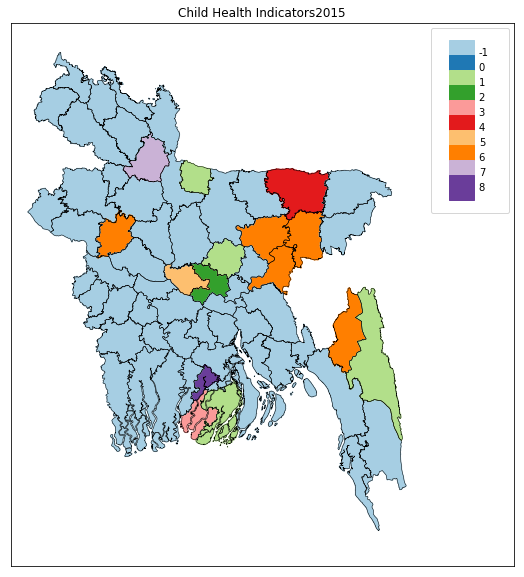

[2016]


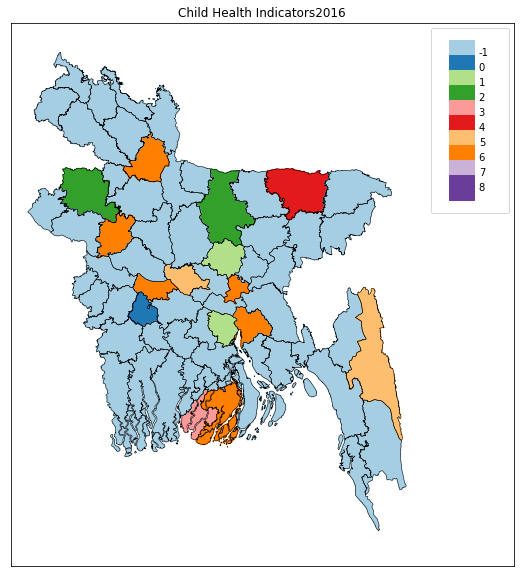

[2017]


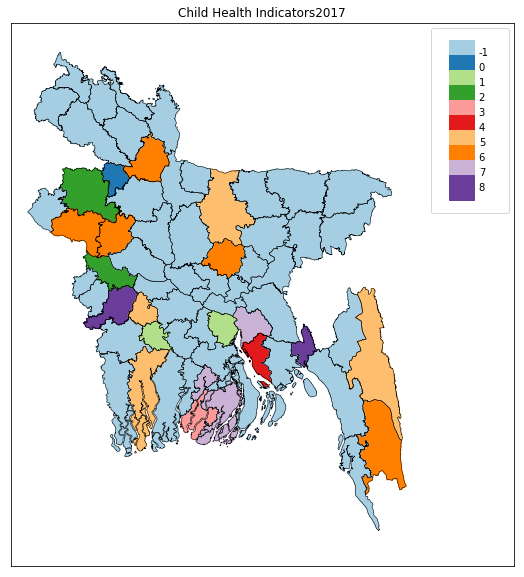

[2018]


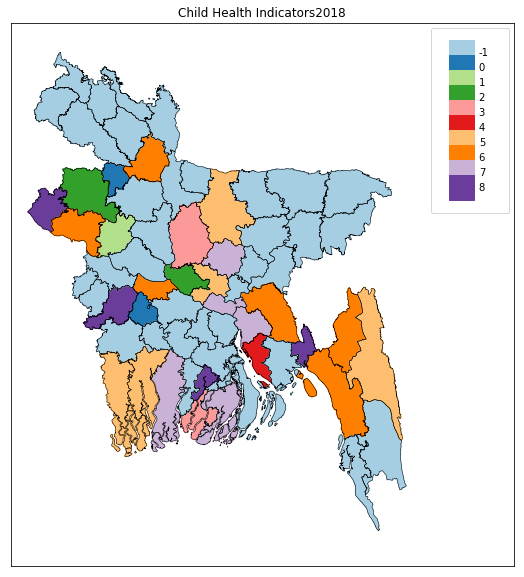

In [30]:
plot_clusters(input_df=datad_option3, shapefile=SHAPEFILE, geo_level=GEO_LEVEL, project=Config.project, output=OUTPUT)

In [31]:
stats = get_statistics(input_df=datad_option1, output=OUTPUT, title=Config.project)
stats

02ChildHealth: % of breast feeding initiated within 1 hour by CSBA
02ChildHealth: IMCI Stunting (%)
02ChildHealth: IMCI Underweight (%)
02ChildHealth: IMCI Wasting (%)
02ChildHealth: Neonatal Case fatality rate (EmOC)
02ChildHealth: Percentage of diarrhea reported at facility
02ChildHealth: Percentage of pneumonia reported at facility
02ChildHealth: % of breast feeding initiated within 1 hour by CSBA
02ChildHealth: IMCI Stunting (%)
02ChildHealth: IMCI Underweight (%)
02ChildHealth: IMCI Wasting (%)
02ChildHealth: Neonatal Case fatality rate (EmOC)
02ChildHealth: Percentage of diarrhea reported at facility
02ChildHealth: Percentage of pneumonia reported at facility
02ChildHealth: % of breast feeding initiated within 1 hour by CSBA
02ChildHealth: IMCI Stunting (%)
02ChildHealth: IMCI Underweight (%)
02ChildHealth: IMCI Wasting (%)
02ChildHealth: Neonatal Case fatality rate (EmOC)
02ChildHealth: Percentage of diarrhea reported at facility
02ChildHealth: Percentage of pneumonia reported a

{2012: class         -1        0        1           2  \
 mean   65.866667  96.0000  89.0000   95.254237   
 std    57.044398      NaN      NaN    4.283461   
 amax   99.300000  96.0000  89.0000  101.900000   
 amin    0.000000  96.0000  89.0000   83.000000   
 mean    2.090000  10.6000   0.0700    0.896949   
 std     2.392551      NaN      NaN    0.963171   
 amax    4.800000  10.6000   0.0700    4.100000   
 amin    0.270000  10.6000   0.0700    0.010000   
 mean    6.300000   8.6000   1.5000    1.639153   
 std     4.746578      NaN      NaN    1.401750   
 amax   11.500000   8.6000   1.5000    7.200000   
 amin    2.200000   8.6000   1.5000    0.070000   
 mean    2.433333   6.6000   0.1200    0.582373   
 std     2.000833      NaN      NaN    0.605576   
 amax    4.400000   6.6000   0.1200    2.900000   
 amin    0.400000   6.6000   0.1200    0.010000   
 mean    1.530833   0.0696   0.4418    0.533190   
 std     1.909108      NaN      NaN    0.916999   
 amax    3.727900   0.069